In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Preprocess

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # for 3channesls (mean, mean, mean), (std, std, std)
    ]
)

# Download dataset

In [3]:
trainset = torchvision.datasets.CIFAR10(
    root='../../data/raw/CIFAR10',
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

In [4]:
testset = torchvision.datasets.CIFAR10(
    root='../../data/raw/CIFAR10',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

In [5]:
testset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Show dataset

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

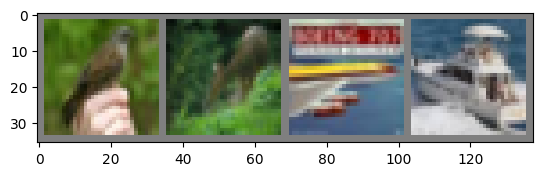

['bird', 'deer', 'airplane', 'ship']


In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print([trainset.classes[label.item()] for label in labels])

# Definition of network

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input 3 image channels, output 6 channels, kernel size 5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 40)
        self.fc4 = nn.Linear(40, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()


# Conv2d -> Liner Dimension transform

In [10]:
npt = np.array([[1, 2, 3, 4], [5, 6, 7, 8]]).reshape(2, 2, 2)
t = torch.from_numpy(npt)

In [11]:
t.view(-1, 8)

tensor([[1, 2, 3, 4, 5, 6, 7, 8]])

# Loss function and optimizer

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train

In [13]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get data from dataset as [inputs, labels]
        inputs, labels = data

        # reset the gradients to zero
        optimizer.zero_grad()

        # forward and backward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'epoch: {epoch + 1}, batch: {i + 1}, loss: {running_loss / 2000}')
            running_loss = 0.0

print('Finished Training')

epoch: 1, batch: 2000, loss: 2.302002428174019
epoch: 1, batch: 4000, loss: 2.145068029642105
epoch: 1, batch: 6000, loss: 1.897101215004921
epoch: 1, batch: 8000, loss: 1.7339172827005387
epoch: 1, batch: 10000, loss: 1.6284305984973908
epoch: 1, batch: 12000, loss: 1.5568352269232273
epoch: 2, batch: 2000, loss: 1.4797206115573645
epoch: 2, batch: 4000, loss: 1.4391230094656349
epoch: 2, batch: 6000, loss: 1.417924277924001
epoch: 2, batch: 8000, loss: 1.389213113129139
epoch: 2, batch: 10000, loss: 1.3805227143988013
epoch: 2, batch: 12000, loss: 1.317725034289062
Finished Training


# Save the weight

In [14]:
PATH = '../../result/model/cifar_net.pth'
torch.save(net.state_dict(), PATH)

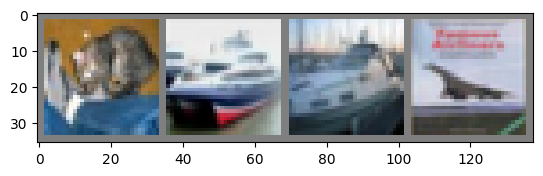

In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# Load the weight

In [16]:
# actually this code is not needed, but just for testing
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{testset.classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   automobile ship  airplane


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy {100 * correct / total}')

Accuracy 53.46


In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {testset.classes[i]}: {100 * class_correct[i] / class_total[i]} %')

Accuracy of airplane: 50.2 %
Accuracy of automobile: 75.0 %
Accuracy of bird: 31.0 %
Accuracy of cat: 23.7 %
Accuracy of deer: 37.6 %
Accuracy of dog: 56.2 %
Accuracy of frog: 74.2 %
Accuracy of horse: 52.3 %
Accuracy of ship: 73.1 %
Accuracy of truck: 61.3 %


# Learning on GPU

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [21]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=10, bias=True)
)

In [22]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'epoch: {epoch + 1}, batch: {i + 1}, loss: {running_loss / 2000}')
            running_loss = 0.0

print('Finished Training')

epoch: 1, batch: 2000, loss: 1.2711645810566843
epoch: 1, batch: 4000, loss: 1.2373547775223852
epoch: 1, batch: 6000, loss: 1.2406788631565868
epoch: 1, batch: 8000, loss: 1.2476424376461654
epoch: 1, batch: 10000, loss: 1.2354470770694315
epoch: 1, batch: 12000, loss: 1.205755442030728
epoch: 2, batch: 2000, loss: 1.1699142795372754
epoch: 2, batch: 4000, loss: 1.1417761946991085
epoch: 2, batch: 6000, loss: 1.1631941536497326
epoch: 2, batch: 8000, loss: 1.148572711471468
epoch: 2, batch: 10000, loss: 1.1205677236132323
epoch: 2, batch: 12000, loss: 1.1345988866407424
Finished Training


# Test GPU Learning result

In [23]:
net.to('cpu')

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=10, bias=True)
)

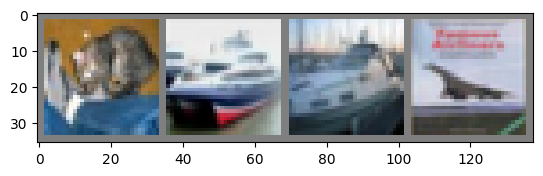

In [24]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [25]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{testset.classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  automobile airplane


In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {testset.classes[i]}: {100 * class_correct[i] / class_total[i]} %')

Accuracy of airplane: 73.3 %
Accuracy of automobile: 75.9 %
Accuracy of bird: 24.4 %
Accuracy of cat: 52.3 %
Accuracy of deer: 52.6 %
Accuracy of dog: 29.3 %
Accuracy of frog: 66.0 %
Accuracy of horse: 76.9 %
Accuracy of ship: 70.6 %
Accuracy of truck: 56.5 %
